# Introduction

A time series is a set of observations on a quantitative variable collected over time. In this tutorial you will be working with NASDAQ, also used to refer to the Nasdaq Composite, an index of more than 3,000 stocks listed on the Nasdaq exchange that includes the world’s foremost technology and biotech giants such as Apple, Google, Microsoft, and Oracle. 

Stock price forcasting is a popular and important topic in finance. We will be performing a technical analysis by looking at the price movement of a stock and use this data to predict its future movements. 

Read more: Nasdaq Definition | Investopedia http://www.investopedia.com/terms/n/nasdaq.asp#ixzz4NMYdzA9h 

## Tutorial Content
The main API used in this tutorial is Yahoo Finance. Statsmodel will be used in the second part of the tutorial.
 

### Part 1: Forecasting with Moving Averages

***Not to be confused with Moving Average Model

In many situation, it is difficult or even impossible to forecast time series data using a causal regression model. However, if you can discover the systematic variation in the data based on past behaviour of the time series variable, we can build a model to forecast future behaviour. The techniques that analyze the past behaviour of a time series varaible to predict the future are referred to as extrapolation models. They are generally in the form:

$\hat{Y}_{t+1} = f(Y_t,Y_{t-1},Y_{t-2},...)$

where $\hat{Y}_{t+1}$ is the predicted value for the time series variable in time period $t+1$

First, we're going to use the Yahoo Finance API to get Apple's stock data for the last 2 years.



In [2]:
#$ pip install pandas-datareader
#$ pip install yahoo-finance
from pandas_datareader import data as wb
import pandas_datareader as pdr
import pandas as pd
import numpy as np

import datetime  

start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2016, 1, 27)
df = wb.DataReader("AAPL", 'yahoo', start, end)

dates =[]
for x in range(len(df)):
    newdate = str(df.index[x])
    newdate = newdate[0:10]
    dates.append(newdate)

df['dates'] = dates

# print df.head()
# print df.tail()


```python
                  Open        High         Low       Close     Volume  \
Date                                                                    
2014-01-02  555.680008  557.029999  552.020004  553.129990   58671200   
2014-01-03  552.860023  553.699989  540.429993  540.980019   98116900   
2014-01-06  537.450005  546.800018  533.599983  543.929993  103152700   
2014-01-07  544.320015  545.959999  537.919975  540.040024   79302300   
2014-01-08  538.809982  545.559990  538.689980  543.460022   64632400   

            Adj Close       dates  
Date                               
2014-01-02  74.819430  2014-01-02  
2014-01-03  73.175958  2014-01-03  
2014-01-06  73.574988  2014-01-06  
2014-01-07  73.048809  2014-01-07  
2014-01-08  73.511417  2014-01-08  
                  Open        High        Low       Close     Volume  \
Date                                                                   
2016-01-21   97.059998   97.879997  94.940002   96.300003   52161500   
2016-01-22   98.629997  101.459999  98.370003  101.419998   65800500   
2016-01-25  101.519997  101.529999  99.209999   99.440002   51794500   
2016-01-26   99.930000  100.879997  98.070000   99.989998   75077000   
2016-01-27   96.040001   96.629997  93.339996   93.419998  133369700   

            Adj Close       dates  
Date                               
2016-01-21  94.687703  2016-01-21  
2016-01-22  99.721977  2016-01-22  
2016-01-25  97.775131  2016-01-25  
2016-01-26  98.315919  2016-01-26  
2016-01-27  91.855917  2016-01-27  

```

### Trends 

It's difficult to determine trends without understanding a stock price in relationship to the previous periods. Identifying trends is one of the key functions of moving averages. Moving averages are lagging indicators, which means that they do not predict new trends, but confirm trends once they have been established. Moving averages are described

$\hat{Y}_{t+1} = \frac{Y_t + Y_{t - 1}+ ... + Y_{t-k+1}}{k}$

The value k states the number of previous periods that will be taken into account when calculating the moving average. In other words, introducing more lag to determine how certain the trader wants to be when identifying a trend.

We will also be using the weighted moving average technique to forecast more than one time period into the future. We must subtitute unobserved values with predicted values. Such that at time period $\hat{Y}_i = \frac{Y_{i-1} + Y_{i-2} + ... Y_{i-k}}{k} $ then $ \hat{Y}_{i+1} = \frac{\hat{Y}_{i} + Y_{i-1} + ... Y_{i-k+1}}{k} $.

In [3]:
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen

<img style="float: left;" src="http://i.imgur.com/NT5mtmg.png">


In [4]:
from collections import deque

class MovingAverage:
    def __init__(self, k):
        self.k = k
        self.total = 0.0
        self.dq = deque()
        
    def update(self,x):       
        if (x == None):
            v = self.total/len(self.dq)
            #Remove outdated value
            self.dq.popleft()
            #Add our prediction as a replacement
            self.dq.append(v)
            return self.total/len(self.dq)
        
        #Add to our queue 
        self.dq.append(x)
        self.total += x
        
        #Drop value in our queue if our queue more than k
        if len(self.dq) > self.k:
            self.total -= self.dq.popleft()
            return self.total/len(self.dq)

def calc_moving_average(s, k):
    MA = MovingAverage(k)
    return pd.Series([ MA.update(x) for x in s.append(pd.Series([None]*k))][k:])

def plot_stocks(df, k):
    #Plot original stock 
    plt.plot(df.index, df.loc[:,'Close'])
    
    #Plot smoothed stock
    avgs = calc_moving_average(df.loc[:,'Close'],k)
    base = df.index[k:][-1]
    date_list = [base + datetime.timedelta(days = x) for x in xrange(0, k)]
    
    plt.plot(list(df.index[k:]) + date_list,avgs,'.')


In [5]:
# plot_stocks(df, 60)    
# plt.show()

#### There are two things to note:

#### 1) We are using Adjusted Close rather than Close for stock prices. 
Why is this important? Here is the output for when we use Close instead:



<img style="float: left;" src="http://i.imgur.com/P5BiQr2.png">

Companies can issue dividends on stocks or perform stock splits that will change the underlying value of the stock.

http://www.investopedia.com/ask/answers/113.asp

In this case, Apple's stock has split four times since the company went public. The stock split on a 7-for-1 basis on June 9, 2014 and split on a 2-for-1 basis on February 28, 2005, June 21, 2000, and June 16, 1987.

#### 2) There are no values for the first k dates.
Since we are using a moving average and not a sliding average. In other words, the trader doesn't have enough data to determine a trend from the existing values.

### Weighted Moving Averages
The simple moving average is popular among traders, but a main critique of this method is that all values from previous periods is weighted the same. Since it is arguable that the most recent data is more significant than older data, it should have greater influence on the final average. We will improve upon the simple moving average by introducing a slight variation by allowing for weights, such that the forecasting function is now represented by

$\hat{Y}_{t+1} = w_1Y_t + w_2Y_{t-1} + ... w_kY_{t-k+1}$ 

where the weights are normalized between 0 and 1 such that $0 \leq w_i \geq 1 $ and $ \sum\limits_{i = 1}^{k} w_i = 1$. Here's we create a linearly weighted moving average, calculated by taking each of the closing prices over a given time period and multiplying them by it's position in the data series and then dividing the value by the sum of the weights. We will be forecasting predicted values using the same method as in the previous case.

In [6]:
from collections import deque

class WeightedMovingAverage:
    def __init__(self, k):
        self.k = k
        #Series of k linear weights 
        self.weights = range(k)
        self.dq = deque()
        
    def update(self,x):  
        
        #Use predicted value to calculate average
        if (x == None):
            v = sum([x*y for x,y in zip(self.weights, self.dq)])/sum(self.weights)
            self.dq.popleft()
            self.dq.append(v)
            return sum([x*y for x,y in zip(self.weights, self.dq)])/sum(self.weights)
            
        #Add to our queue 
        self.dq.append(x)
        
        #Drop value in our queue if our queue more than k
        if len(self.dq) >= self.k:
            if len(self.dq) > self.k: self.dq.popleft()
            #Calculate total based off weights
            return sum([x*y for x,y in zip(self.weights, self.dq)])/sum(self.weights)

def calc_weighted_moving_average(s, k):
    MA = WeightedMovingAverage(k)
    return pd.Series([ MA.update(x) for x in s.append(pd.Series([None]*k))][k:])

def plot_weighted_stocks(df, k):
    #Plot original stock 
    plt.plot(df.index, df.loc[:,'Adj Close'])
    
    #Plot smoothed stock
    avgs = calc_weighted_moving_average(df.loc[:,'Adj Close'],k)
    base = df.index[k:][-1]
    date_list = [base + datetime.timedelta(days = x) for x in xrange(0, k)]
    plt.plot(list(df.index[k:]) + (date_list),avgs,'.')

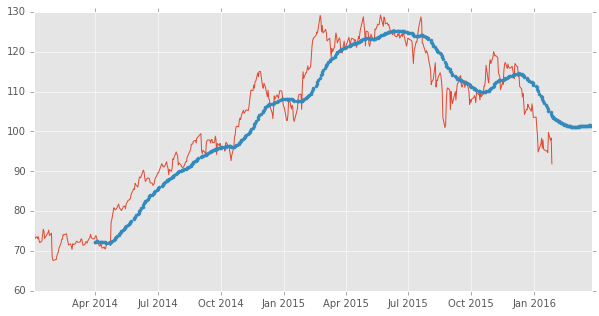

In [7]:
plot_weighted_stocks(df, 60)    
plt.show()

<img style="float: left;" src="http://i.imgur.com/U8o7jC8.png">


#### Note 
We can observe that the lag is not as bad as in the linear moving average. 

### Exponential Moving Average

The issue with simple weighted moving averages is that most recent data should be weighted more significantly than historical data (consider how quickly some companies evolve).The exponential moving average also assigns a weighting factor to each value in the data series according to its age. The difference between this technique and the moving average weighted average is the weight of each data point decreases exponentially. The equation for $\hat{Y}_{t+1}$ is

$\hat{Y}_{t+1} = \hat{Y_t} + \alpha(Y_t-\hat{Y_t})$ 



In [8]:
from collections import deque

class ExponentialMovingAverage:
    def __init__(self, k, alpha):
        #Series of k linear weights 
        self.k = k
        self.alpha = float(alpha)
        self.dq = deque()
        
    def update(self, x):  
        #Use predicted value to calculate average
        if (x == None):
            val1 = self.dq.popleft()
            val2 = self.dq.popleft()
            predicted = val2 + self.alpha*(val1-val2)
            #We have to use our predicted values in place of real observed values so we append twice
            self.dq.append(predicted)
            self.dq.append(predicted)
            return predicted
                
        self.dq.append(x)
        
        #Set inital value
        if len(self.dq) == 1:
            self.dq.append(x)
            return x
        
        val1 = self.dq.popleft()
        val2 = self.dq.popleft()
        predicted = val2 + self.alpha*(val1 - val2)
        self.dq.append(predicted)
        
        return predicted

def calc_exponential_moving_average(s, k, alpha):
    MA = ExponentialMovingAverage(k, alpha)
    return pd.Series([ MA.update(x) for x in s.append(pd.Series([None]*k))])

def plot_exponential_stocks(df, k, alpha):
    #Plot original stock 
    plt.plot(df.index, df.loc[:,'Adj Close'])
    
    #Plot smoothed stock
    avgs = calc_exponential_moving_average(df.loc[:,'Adj Close'],k,alpha)

    base = df.index[k:][-1]
    date_list = [base + datetime.timedelta(days = x) for x in xrange(0, k)]
    plt.plot(list(df.index) + (date_list),avgs)

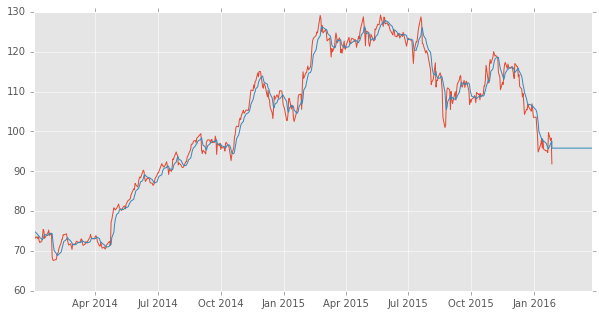

In [9]:
plot_exponential_stocks(df, 60, 0.3)    
plt.show()

<img style="float: left;" src="http://i.imgur.com/dRPHJeF.png">

#### Note:  
Alpha is a smoothing factor where smaller values produce more lagged results as predictions do not react as quickly to recent data. Also, notice that the predictions flatten out. For traders who trade intraday and fast-moving markets, the EMA is more applicable. 

Now would be a good time to emphasize that moving averages (what we did above) is different than a moving-average model. In a moving average regression model, a variable of interest is assumed to be a weighted moving average of unobserved independent error terms. The weights in the moving average are parameters to be estimated. MA models are always stationary and therefore, is  innappropriate to use with our current dataset as it is. 

### Part 2: Making Time Series Data Stationary 
Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary over time. The above methods above were used to confirm trends, rather than act as reliable predictors (often the window of opportunity has passed once the trend has been confirmed). If stationary data is characterized by the same persistent statistical properties - then we could reliably predict future values. 

With that said, non-stationary data can be made stationary through a couple of techniques. There are two causes of non-stationarity in a time series. <br>

#### Trend: 
Varying mean over time 

#### Season:
Variations in data at specific-time frames. E.g. Apple experiences strong bull (expected to rise) markets in Autumn - Spring period (Apple special events are usually in early September and late March).

A series is stationary if it has a constant: <br>

#### Mean
#### Variance
#### Autocovariance that does not depend on time 

We will formally confirm that the data is non-stationary even though it's a little redundant. The Dickey-Fuller tests the null hypothesis of whether a unit root is present in an autoregressive model where AR(1)

$y_t = py_{t-1} + u_t$

where $y_t$ is the variable of interest, $u_t$ is the error and $p$ is the coefficient. If $p$ is equal to 1, that means that the autovariance does depend on time, and therefore, the data is not stationary. 


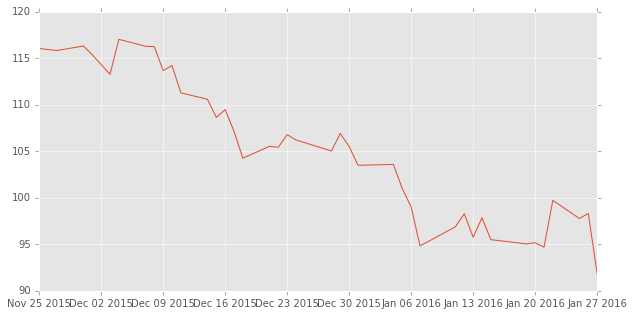

In [10]:
#We're going just work with approximately two months worth of trading 
#data with a downward trend

data = df.loc[:,'Adj Close'][-42:]
plt.plot(data)

<img style="float: left;" src="http://i.imgur.com/RJFwXqr.png">

In [11]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(data)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#print dfoutput

```python
Test Statistic                 -0.953860
p-value                         0.769719
#Lags Used                     10.000000
Number of Observations Used    31.000000
dtype: float64
```

Since the p-value > 0.05, we can not reject the null hypothesis that there is a unit root. Logging a series often has an effect very similar to deflating: it straightens out exponential growth patterns. Therefore, we will first take the log transformation and then the first difference. 

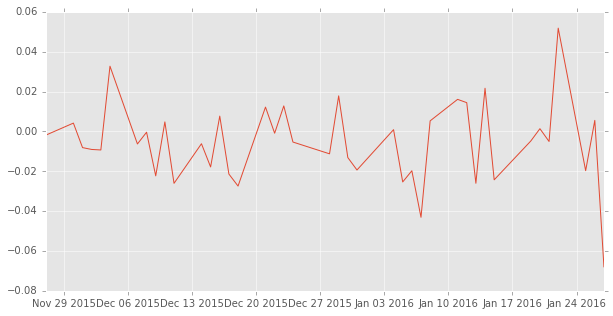

In [12]:
ts_log = np.log(data)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

<img style="float: left;" src="http://i.imgur.com/PiRmWWx.png">

In [13]:
ts_log_diff.dropna(inplace=True)
dftest = adfuller(ts_log_diff)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#print dfoutput

```python
Test Statistic                 -4.467828
p-value                         0.000225
#Lags Used                      9.000000
Number of Observations Used    31.000000
dtype: float64
```

Since the p-value < 0.05, we reject the null hypothesis that there is a unit root. The data is now relatively stationary.

### Part 3a: Auto-regressive Modeling 
An autoregressive model (AR) is a representation of a type of a stochastic process in which future values are estimated based on a weighted sum of past values. The AR(p) model is defined as:

$X_t = c + \sum\limits_{i = 1}^p\varphi_i X_{t-1} + \epsilon$

where 
$c$ is a constant
$p$ is the lags of dependent variables (if $p$ is 5, the predictors of $x(t)$ will be $x(t-1)$...$x(t-5)$

We predict the number of lags by considering the partial autocorrelation graph. The partial autocorrelation is the amount of correlation between a variable and a lag of itself that is not explained by the lower order lags. 

We will use a 95% confidence interval, defined as
$ \Delta = 0 \pm \frac{1.96}{\sqrt{L}} $

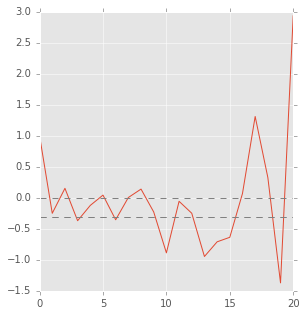

In [14]:
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf

#Calculate confidence interval
ci = -1.96/np.sqrt(len(ts_log_diff))
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=ci,linestyle='--',color='gray')
plt.axhline(y=ci,linestyle='--',color='gray')

<img style="float: left;" src="http://i.imgur.com/3T6xXSr.png">

The two dotted lines on either sides of 0 are the confidence intervals (95%). The p we choose is the lag value where the PACF chart enters the upper confidence intervals for the first time. (We see a large spike at lag 1 indicating that most of the higher order lags can be explained by lag 1).

1 will the autoregressive term. We can model the AR model using statsmodel ARIMA. A nonseasonal ARIMA model is classified as an ARIMA(p,d,q) model, where:

p is the number of autoregressive terms, <br>
d is the number of nonseasonal differences needed for stationarity, and <br>
q is the number of lagged forecast errors in the prediction equation.

In our model p = 1 (determined above), d = 1 and q = 0 (lagged forecast errors used for Moving average models).

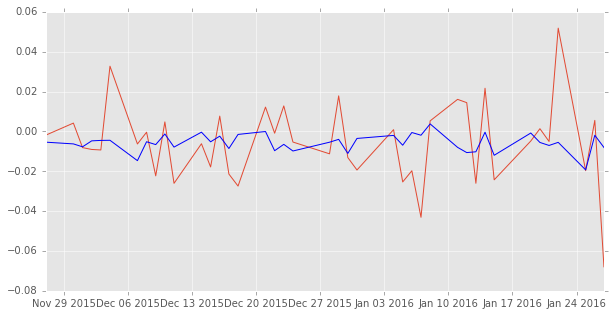

In [15]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order = (1,1,0)) #Parameters described above
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues,color='blue')

<img style="float: left;" src="http://i.imgur.com/wpcB7WF.png">

### Part 3b: MA Modeling

MA Modeling defined as

$X_t = \mu + \epsilon_t + \theta\epsilon_{t-1} + ... + \theta_q\epsilon_{t-1}$


where $\mu$ is the mean of the series and $\theta_1,...\theta_q$ are the parameters and the $\epsilon_t,\epsilon_{t-1},...\epsilon{t-q}$ are the errors. We are trying to find value q. <br> <br>
Autocorrelation is the correlation of a signal with itself at different points in time. 

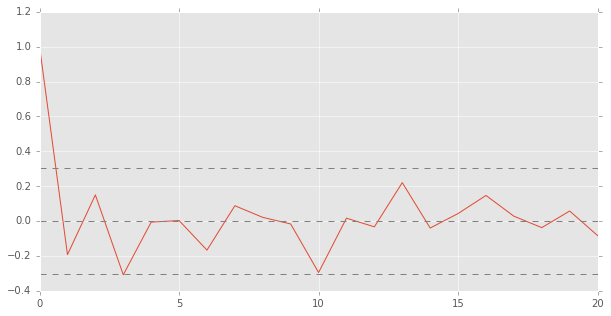

In [16]:
lag_acf = acf(ts_log_diff, nlags=20)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')

<img style="float: left;" src="http://i.imgur.com/XrzlJmZ.png">

We can see that that the observed values only are statistically significant for a time period of 1. 

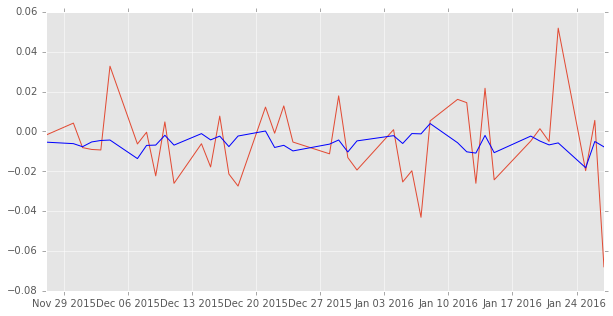

In [17]:
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1, trend='c')  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='blue')

<img style="float: left;" src="http://i.imgur.com/DRhn4FO.png">\

#### Note

We see that using AR(1) and MA(1) in this case does not yield very different results. 

### Part 3: ARIMA Modeling 
Arima modeling is a combination of the AR model and moving average model. Recall 

AR(p) is defined as $X_t = c + \sum\limits_{i = 1}^p\varphi_i X_{t-1} + \epsilon$ <br>
MA(q) is defined as $X_t = \mu + \epsilon_t + \theta\epsilon_{t-1} + ... + \theta_q\epsilon_{t-1}$

AR models and MA models do not have to be combined, and often do not produce better results. In our case, combining the models did not produce significantly better results. The process below is for demonstration purposes.

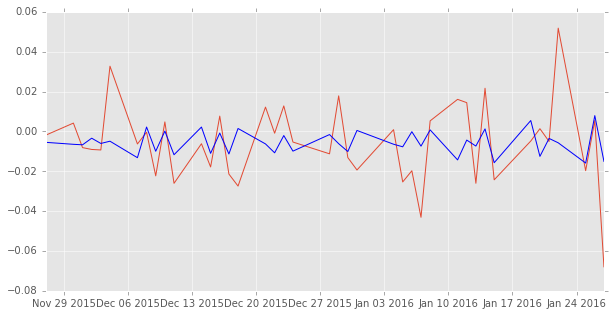

In [18]:
model = ARIMA(ts_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='blue')

<img style="float: left;" src="http://i.imgur.com/xLIclHB.png">\

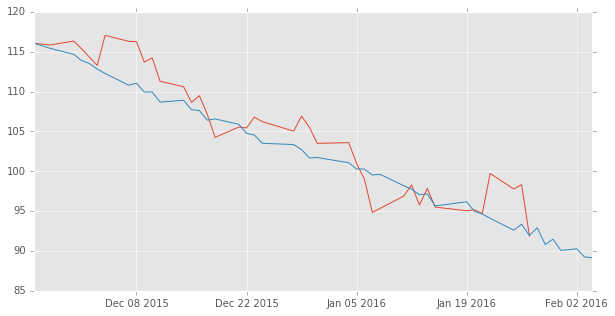

In [19]:
import datetime as dt 

predictions = pd.Series(results_ARIMA.fittedvalues, copy = True)

# We're going to add the differences to our log values
predictions_ARIMA_diff_cumsum = predictions.cumsum()

predictions_log = pd.Series(ts_log.ix[0], index = ts_log.index)
predictions_log = predictions_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
f_days_pred = 7
future_predictions = results_ARIMA.forecast(f_days_pred)[0]

#Add future predictions for the next days
for i in xrange(f_days_pred):
    last_d = predictions_log.index[-1].date()
    if last_d.isoweekday() in set((6,7)):
        d = last_d + datetime.timedelta(days=last_d.isoweekday()%5)
    else: d = last_d + datetime.timedelta(days=1)
    to_add = pd.Series([future_predictions[i]], index=[pd.Timestamp(d)])
    predictions_log = predictions_log.append(to_add)
    
ts_post = np.exp(predictions_log)

plt.plot(data)
plt.plot(ts_post)

<img style="float: left;" src="http://i.imgur.com/PJx2t5N.png">\

This concludes the stock forecasting tutorial. Just remember that technical analysis of stocks do not result in absolute predictions - they only inform investors about what is likely to happen to prices over time. <br>


## Further reading

#### Yahoo Finance API
http://meumobi.github.io/stocks%20apis/2016/03/13/get-realtime-stock-quotes-yahoo-finance-api.html
#### Weighted Moving Average
http://www.investopedia.com/articles/technical/060401.asp
#### Linear Weighted Moving Average
http://www.investopedia.com/terms/l/linearlyweightedmovingaverage.asp

#### ARIMA Models
https://people.duke.edu/~rnau/411arim.htm

#### Stock Market Prediction
https://en.wikipedia.org/wiki/Stock_market_prediction

## References
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

Spreadsheet Modeling and Decision Analysis: A Practical Introduction to Business Analytics by Cliff Ragsdale